Resnet 50 에서 최고의 accuracy 0.75로 활성화함수는 ReLU대신 SiLU를 사용했고, dropout을 0.7로 세팅함.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random as rn
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from PIL import Image

import json
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [ ]:
X_train = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/X_train_data_with_aug_64.npy')
X_val = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/X_val_data_with_aug_64.npy')
X_test = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/X_test_data_with_aug_64.npy')
Y_train = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/Y_train_data_with_aug_64.npy')
Y_val = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/Y_val_data_with_aug_64.npy')
Y_test = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/Y_test_data_with_aug_64.npy')

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (3622, 64, 64, 3)
X_test shape: (284, 64, 64, 3)
Y_train shape: (3622, 3)
Y_test shape: (284, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255.0)
valid_generator = ImageDataGenerator(rescale=1/255.0)

In [ ]:
flow_tr_gen = train_generator.flow(X_train, Y_train, batch_size=16, shuffle=True)
flow_val_gen = valid_generator.flow(X_val, Y_val, batch_size=16, shuffle=False)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
IMAGE_SIZE = 64

base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)

output = Dense(3, activation='softmax', name='output')(x)

model = Model(inputs=base_model.input, outputs=output)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

train_generator = train_datagen.flow(X_train, Y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=16)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=16)

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[rlr, ely])

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
227/227 [==============================] - 61s 82ms/step - loss: 1.6601 - accuracy: 0.4205 - val_loss: 1.1148 - val_accuracy: 0.5199 - lr: 1.0000e-04
Epoch 2/50
227/227 [==============================] - 13s 56ms/step - loss: 1.0775 - accuracy: 0.5326 - val_loss: 0.8761 - val_accuracy: 0.5905 - lr: 1.0000e-04
Epoch 3/50
227/227 [==============================] - 13s 58ms/step - loss: 0.8194 - accuracy: 0.6328 - val_loss: 0.8065 - val_accuracy: 0.6325 - lr: 1.0000e-04
Epoch 4/50
227/227 [==============================] - 14s 60ms/step - loss: 0.6744 - accuracy: 0.6946 - val_loss: 0.7475 - val_accuracy: 0.6534 - lr: 1.0000e-04
Epoch 5/50
227/227 [==============================] - 12s 53ms/step - loss: 0.5247 - accuracy: 0.7794 - val_loss: 0.7201 - val_accuracy: 0.6766 - lr: 1.0000e-04
Epoch 6/50
227/227 [==============================] - 12s 54ms/step - loss: 0.4171 - accuracy: 0.8332 - val_loss: 0.7696 - val_acc

In [ ]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

9/9 [==============================] - 2s 60ms/step
Confusion Matrix:
[[98 20  3]
 [50 49  6]
 [12 31 15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.81      0.70       121
           1       0.49      0.47      0.48       105
           2       0.62      0.26      0.37        58

    accuracy                           0.57       284
   macro avg       0.58      0.51      0.51       284
weighted avg       0.57      0.57      0.55       284



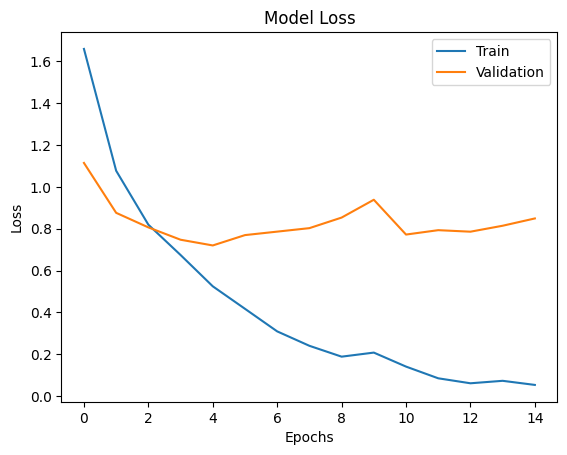

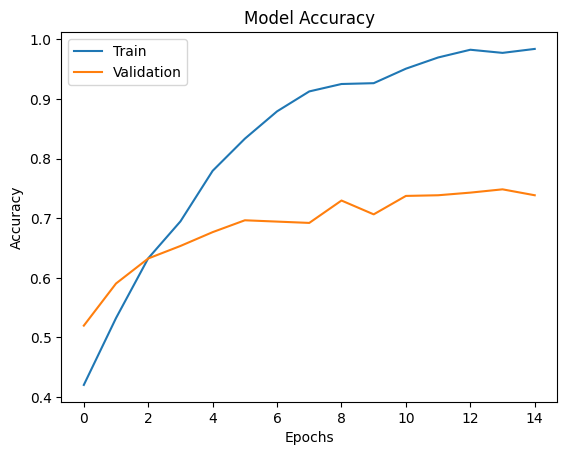

In [ ]:
# Plotting training loss and validation loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# SiLU 사용
def silu(x):
    return x * tf.keras.activations.sigmoid(x)

IMAGE_SIZE = 64
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.7)(x)
x = Dense(200, activation=silu, name='fc1')(x)
x = Dropout(rate=0.7)(x)

output = Dense(3, activation='softmax', name='output')(x)

model = Model(inputs=base_model.input, outputs=output)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

train_generator = train_datagen.flow(X_train, Y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=16)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=16)

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[rlr, ely])

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/100
227/227 [==============================] - 45s 61ms/step - loss: 2.6874 - accuracy: 0.3854 - val_loss: 1.3407 - val_accuracy: 0.4812 - lr: 1.0000e-04
Epoch 2/100
227/227 [==============================] - 13s 59ms/step - loss: 1.6040 - accuracy: 0.4467 - val_loss: 1.0471 - val_accuracy: 0.5442 - lr: 1.0000e-04
Epoch 3/100
227/227 [==============================] - 12s 54ms/step - loss: 1.2284 - accuracy: 0.4796 - val_loss: 0.8941 - val_accuracy: 0.5695 - lr: 1.0000e-04
Epoch 4/100
227/227 [==============================] - 13s 59ms/step - loss: 1.0512 - accuracy: 0.5414 - val_loss: 0.8311 - val_accuracy: 0.6015 - lr: 1.0000e-04
Epoch 5/100
227/227 [==============================] - 13s 58ms/step - loss: 0.9416 - accuracy: 0.5768 - val_loss: 0.8202 - val_accuracy: 0.6049 - lr: 1.0000e-04
Epoch 6/100
227/227 [==============================] - 14s 61ms/step - loss: 0.8180 - accuracy: 0.6317 - val_loss: 0.7768 - val_accuracy: 0.6192 - lr: 1.0000e-04
Epoch 7/100
227/227 [=======

In [ ]:
model.save('resnet_aug_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

model_path = '/content/drive/MyDrive/딥러닝 팀플/model/resnet_aug_model.h5'
model = load_model(model_path)

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

9/9 [==============================] - 1s 21ms/step
Confusion Matrix:
[[88 20 13]
 [31 40 34]
 [ 5 14 39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       121
           1       0.54      0.38      0.45       105
           2       0.45      0.67      0.54        58

    accuracy                           0.59       284
   macro avg       0.57      0.59      0.57       284
weighted avg       0.59      0.59      0.58       284



In [ ]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

9/9 [==============================] - 1s 21ms/step
Confusion Matrix:
[[88 20 13]
 [31 40 34]
 [ 5 14 39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       121
           1       0.54      0.38      0.45       105
           2       0.45      0.67      0.54        58

    accuracy                           0.59       284
   macro avg       0.57      0.59      0.57       284
weighted avg       0.59      0.59      0.58       284



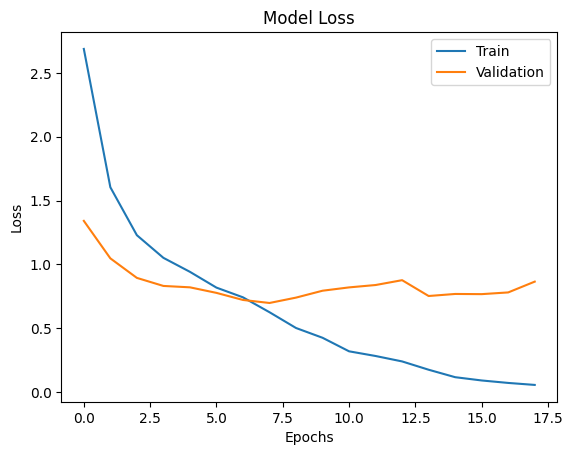

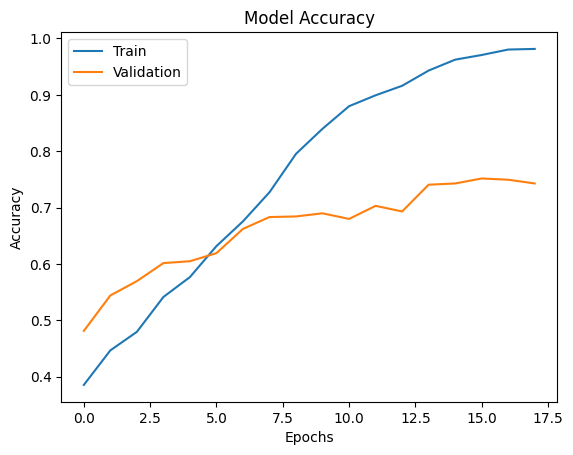

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('model_loss_plot.png')
plt.show()

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('model_accuracy_plot.png')
plt.show()